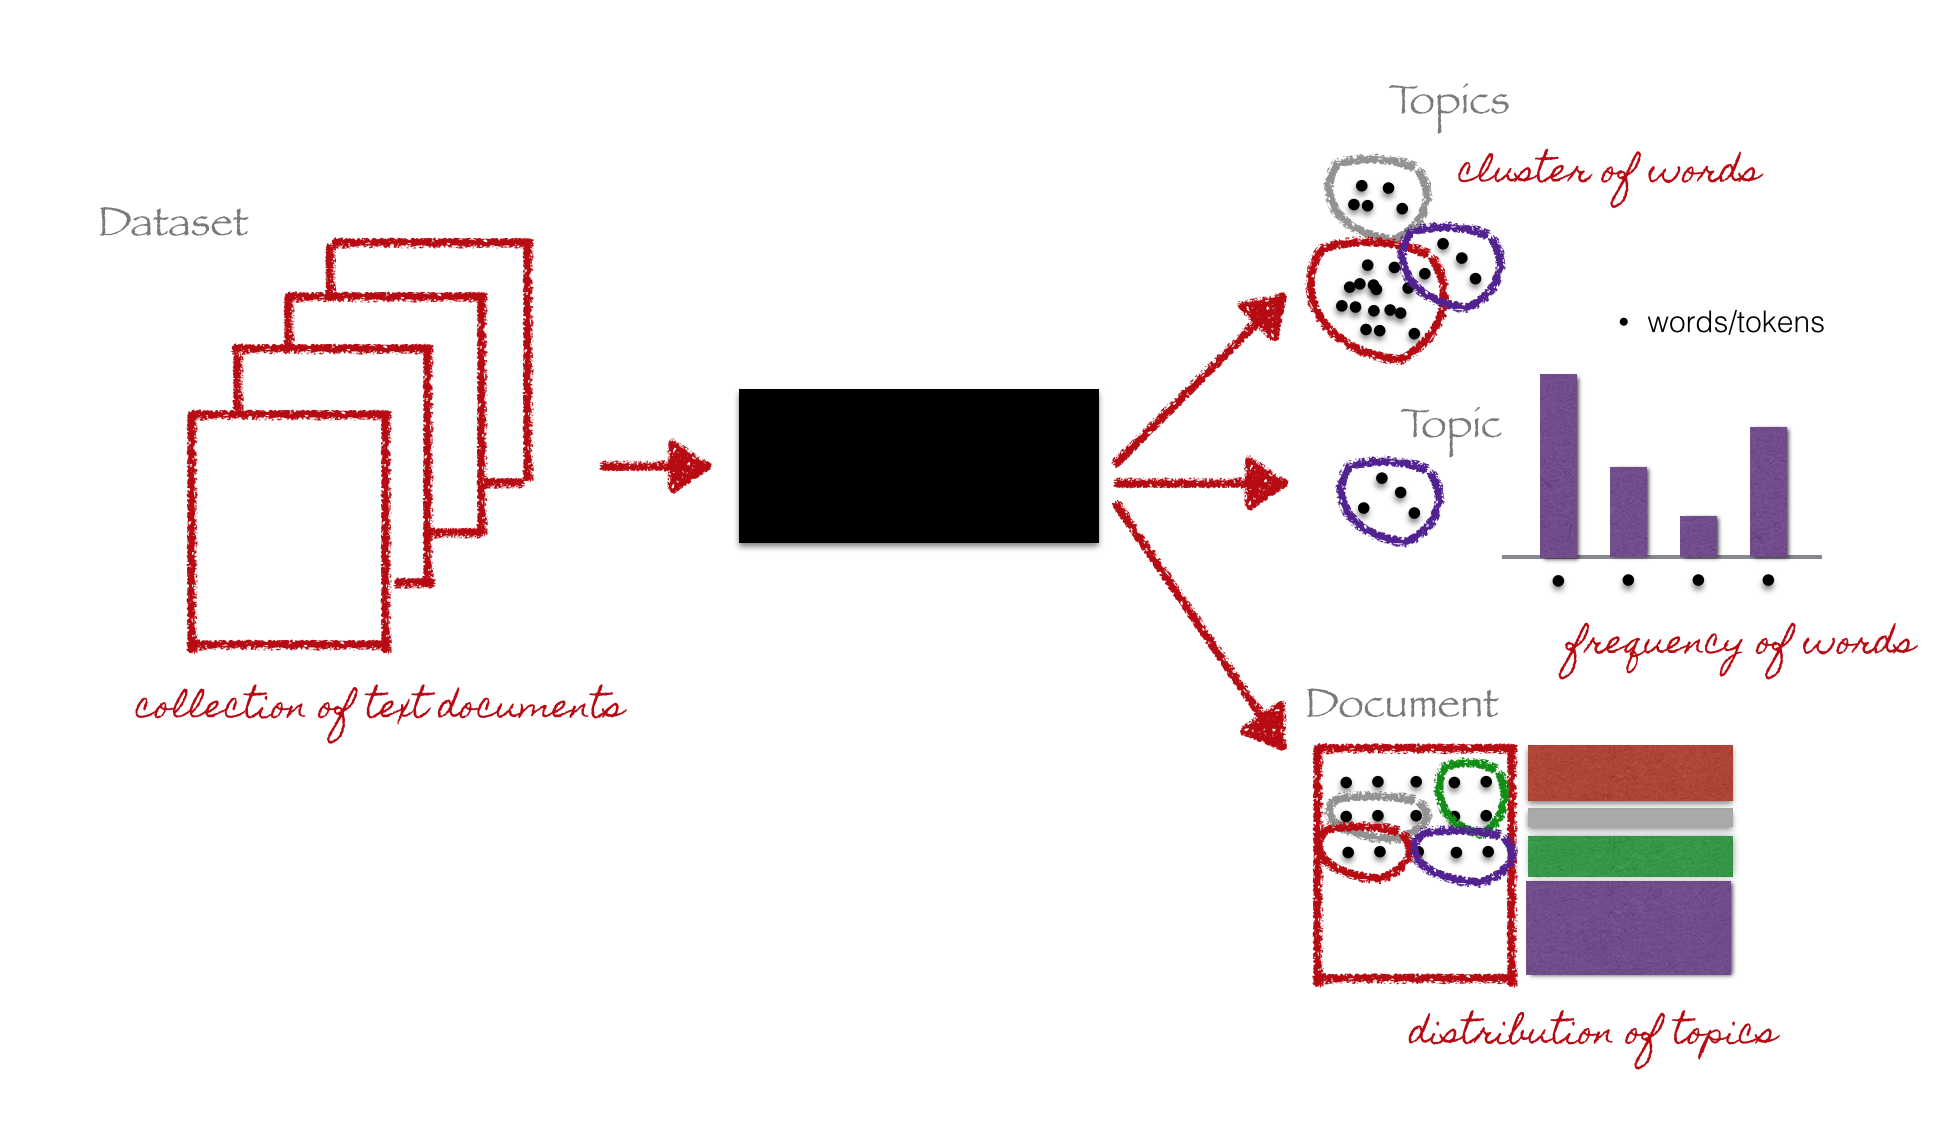

In [1]:
from IPython.display import Image
Image("TopicModeling.png",width=400,height=350)

In [1]:
#we are importing email package for convenience
import os, sys, email,re
from gensim.models import CoherenceModel
import numpy as np 
from gensim.utils import simple_preprocess
import pandas as pd
from nltk.corpus import stopwords
from palettable.tableau import Tableau_20
import json
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud
from os import listdir, chdir
# Network analysis
import gensim
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from stop_words import get_stop_words

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# To build the dictionary
from collections import defaultdict
from gensim.models.phrases import Phrases, Phraser
import spacy

nlp = spacy.load("en_core_web_sm")

<h1 align="center"> Topic modelling using LDA </h1>


<h2>About Dataset </h2>
The Enron database (specifically the emails in the employees 'sent' directories) 
is analysed using Latent Dirichlet allocation (LDA). The Gensim library is used to perform the LDA analysis. 
This provides a number of key words for each of the 20 topics considered. 
From here, custom functions are implemented in order to analyse the prevalence of key words within a 
document of the users choice. Functions are also created to determine the key topics for a specific 
employee as well as to determine the employees of note for a given topic.

<h2> Defining the regular expressions and importing the dataset </h2>

In [2]:
emails_df=pd.read_csv('Enron_emails_small.csv')
emails_df=emails_df.iloc[:,1:]

print("successfully loaded {} rows and {} columns!".format (emails_df.shape[0], emails_df.shape[1]))
print(emails_df.head())

successfully loaded 15522 rows and 2 columns!
                         file  \
0  jones-t/all_documents/634.   
1  mann-k/all_documents/5690.   
2        dasovich-j/sent/423.   
3          kaminski-v/var/63.   
4     mann-k/_sent_mail/3208.   

                                             message  
0  Message-ID: <17820178.1075846925335.JavaMail.e...  
1  Message-ID: <29110382.1075845717882.JavaMail.e...  
2  Message-ID: <6812040.1075843194135.JavaMail.ev...  
3  Message-ID: <21547648.1075856642126.JavaMail.e...  
4  Message-ID: <12684200.1075846107179.JavaMail.e...  


In [3]:
#returns a message object structure from a string.
Messages=list(map(email.message_from_string,emails_df['message']))

In [4]:
emails_df.drop('message',axis=1,inplace=True)

In [5]:
keys=Messages[0].keys()

In [6]:
for key in keys:
    emails_df[key]=[doc[key] for doc in Messages]

In [8]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,jones-t/all_documents/634.,<17820178.1075846925335.JavaMail.evans@thyme>,"Tue, 4 Jan 2000 08:20:00 -0800 (PST)",tana.jones@enron.com,alicia.goodrow@enron.com,Re: Dinner,1.0,text/plain; charset=us-ascii,7bit,Tana Jones,Alicia Goodrow,,,\Tanya_Jones_Dec2000\Notes Folders\All documents,JONES-T,tjones.nsf
1,mann-k/all_documents/5690.,<29110382.1075845717882.JavaMail.evans@thyme>,"Tue, 15 May 2001 11:03:00 -0700 (PDT)",kay.mann@enron.com,sheila.tweed@enron.com,Re: Override letter,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,Sheila Tweed,,,\Kay_Mann_June2001_1\Notes Folders\All documents,MANN-K,kmann.nsf
2,dasovich-j/sent/423.,<6812040.1075843194135.JavaMail.evans@thyme>,"Thu, 28 Sep 2000 08:59:00 -0700 (PDT)",jeff.dasovich@enron.com,christine.piesco@oracle.com,Teams,1.0,text/plain; charset=us-ascii,7bit,Jeff Dasovich,Christine.Piesco@oracle.com,,,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf
3,kaminski-v/var/63.,<21547648.1075856642126.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 01:23:00 -0700 (PDT)",tanya.tamarchenko@enron.com,vince.kaminski@enron.com,Re: FYI: UK Var issues,1.0,text/plain; charset=us-ascii,7bit,Tanya Tamarchenko,Vince J Kaminski,,,\Vincent_Kaminski_Jun2001_5\Notes Folders\Var,Kaminski-V,vkamins.nsf
4,mann-k/_sent_mail/3208.,<12684200.1075846107179.JavaMail.evans@thyme>,"Fri, 13 Oct 2000 01:50:00 -0700 (PDT)",kay.mann@enron.com,"lisa.bills@enron.com, ben.jacoby@enron.com",Change Order #5--Pleasanton Transformer,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,"Lisa Bills, Ben Jacoby",,,\Kay_Mann_June2001_4\Notes Folders\'sent mail,MANN-K,kmann.nsf


In [7]:
def get_text_from_email(msg):
    parts=[]
    # each part is a either non-multipart, or another multipart message
    # that contains further parts... Message is organized like a tree
    for part in msg.walk():
        if part.get_content_type() =='text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [8]:
def split_email_address(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs    

In [9]:
emails_df['content']=list(map(get_text_from_email,Messages))

In [11]:
#collect body of emails together using list
doc=emails_df.content.values.tolist()

In [12]:
#deacc True removes punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [13]:
doc_words=list(sent_to_words(doc))

In [15]:
#4th email body looks like this
doc_words[0]

['it',
 'would',
 'be',
 'nice',
 'if',
 'you',
 'could',
 'be',
 'at',
 'my',
 'dinner',
 'since',
 'probably',
 'won',
 'know',
 'anyone',
 'else',
 'anytime',
 'you',
 'want',
 'to',
 'go',
 'to',
 'lunch',
 'to',
 'check',
 'on',
 'the',
 'house',
 'status',
 'be',
 'glad',
 'to',
 'go']

<b> N-Grams:Tokens that Flock together </b>

In [14]:
#Our knowledge language gives us intuition that when two or three words consistently go together, 
#there is richer meaning conveyed compared to with an indiividual word

#Buld Bigram model using gensim API, higher threshold fewer phrases
bigram = Phrases(doc_words, min_count=5, threshold=100)
bigram_mod=Phraser(bigram)
print(bigram_mod[doc_words[20]])

['just', 'reminder', 'that', 'when', 'entering', 'wheel', 'the', 'interchange', 'id', 'must', 'be', 'the', 'same', 'for', 'the', 'import', 'and', 'export', 'when', 'the', 'import', 'is', 'labeled', 'as', 'epmi_ciso_', 'and', 'the', 'export', 'as', 'ciso_epmi_', 'the', 'iso', 'views', 'these', 'as', 'unique', 'imports', 'and', 'exports', 'they', 'will', 'not', 'be', 'linked', 'together', 'for', 'wheel', 'thus', 'causing', 'ancillary', 'services', 'charges', 'to', 'occur', 'thank', 'you']


In [15]:
#remove stopwords as they do not pack a lot of meaning in given text such as is, the, that, which
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject','edu', 'use','com','mailto','ect','www','hou'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

<b> Lemmatization :Getting to the base word </b>

In [17]:
# use Spacy to restrict lemmatization to different parts of speech-Noun,Adjective, Verb and Adverb 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
def preprocess(list_text):
    result=[]
    for i in list_text:
        new_list=[]
        for j in i:
            if len(j)>2:
                new_list.append(j)
            else:
                pass
        result.append(new_list)
    return result   

In [19]:
data_words_nostops=remove_stopwords(doc_words)
data_word_bigrams=make_bigrams(data_words_nostops)
data_lemmatized=lemmatization(data_word_bigrams,allowed_postags=['NOUN','ADJ','VERB','ADV'])
data_preprocessed=preprocess(data_lemmatized)

In [20]:
#get the frequency of the words in text
flat_list = [item for sublist in data_preprocessed for item in sublist]

d = defaultdict(int)
for word in flat_list:
        d[word] += 1 

In [21]:
d['energy']

8906

Below, we construct the document term matrix whereafter the fairly lengthy process of constructing the model takes place. 
Thus far the model seems be linear. 
With a single pass, the model takes just upward of a minute to execute, whereas for 2 passes, the model takes roughly 5 minutes.

In [22]:
#Processing text requires us to represent the tokens and text numerically.One common way to manage this is by creating an index to word mapping.
dictionary=corpora.Dictionary(data_preprocessed)  #The output of this is a dictionary of sorts
corpus=[dictionary.doc2bow(text) for text in data_preprocessed] #Apply dictionary factoring term frequency to all our text to create a corpus

In [35]:
#Corpus is a Stream of document vectors or sparse matrix of shape (num_terms, num_documents)
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=20, id2word = dictionary, passes=2)

In [36]:
#values shows how important a token is whithin that topic
print(ldamodel.print_topics())

[(0, '0.013*"market" + 0.010*"contract" + 0.009*"energy" + 0.008*"price" + 0.008*"ferc" + 0.007*"capacity" + 0.007*"date" + 0.007*"transaction" + 0.006*"gas" + 0.006*"order"'), (1, '0.022*"power" + 0.019*"say" + 0.019*"energy" + 0.014*"state" + 0.011*"california" + 0.010*"price" + 0.009*"utility" + 0.008*"market" + 0.008*"company" + 0.008*"electricity"'), (2, '0.050*"enron" + 0.039*"send" + 0.024*"mail" + 0.019*"message" + 0.015*"original_message" + 0.014*"thank" + 0.013*"email" + 0.011*"receive" + 0.011*"copy" + 0.010*"information"'), (3, '0.027*"game" + 0.025*"week" + 0.021*"update" + 0.015*"play" + 0.012*"team" + 0.011*"start" + 0.010*"yard" + 0.010*"last" + 0.009*"sportsline" + 0.008*"player"'), (4, '0.074*"font" + 0.051*"href" + 0.036*"http" + 0.028*"table" + 0.027*"font_face" + 0.023*"font_size" + 0.023*"size" + 0.022*"width" + 0.016*"tr_td" + 0.015*"td_tr"'), (5, '0.030*"attempt" + 0.025*"cera" + 0.023*"initialize" + 0.023*"engine_error" + 0.023*"error_occurre" + 0.019*"meter" +

<b> Model Perplexity and Coherence </b>

perplexity is a measurement of how well a probability distribution or probability model predicts a sample. 
A low perplexity indicates the probability distribution is good at predicting the sample
Coherence quantify the semantic similarities of the high scoring words within each topic.
A high score means the result is more human-interpretable.

In [37]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))


Perplexity:  -9.774553373818764


In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_preprocessed, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5379635913783825


In [38]:
# Save the ldamodel
ldamodel.save('ldamodel')

# Load ldamodel
ldamodel = gensim.models.LdaModel.load('ldamodel')

We now print the words for each of the given topics. 
It must be noted, that even though considerable emphasis has been placed on the construction of the regular expressions, 'junk-text' may be present.

In [39]:
num_topics = 20
num_words = 15

List = ldamodel.print_topics(num_topics, num_words)
Topic_words =[]
for i in range(0,len(List)):
    word_list = re.sub(r'(.\....\*)|(\+ .\....\*)', '',List[i][1])
    temp = [word for word in word_list.split()]
    Topic_words.append(temp)
    print('Topic ' + str(i) + ': ' + '\n' + str(word_list))
    print('\n' + '-'*100 + '\n')

Topic 0: 
"market" "contract" "energy" "price" "ferc" "capacity" "date" "transaction" "gas" "order" "follow" "customer" "rate" "issue" "request"

----------------------------------------------------------------------------------------------------

Topic 1: 
"power" "say" "energy" "state" "california" "price" "utility" "market" "company" "electricity" "plant" "gas" "year" "time" "bill"

----------------------------------------------------------------------------------------------------

Topic 2: 
"enron" "send" "mail" "message" "original_message" "thank" "email" "receive" "copy" "information" "confidential" "corp" "october" "contact" "thursday"

----------------------------------------------------------------------------------------------------

Topic 3: 
"game" "week" "update" "play" "team" "start" "yard" "last" "sportsline" "player" "season" "pass" "defense" "good" "allow"

----------------------------------------------------------------------------------------------------

Topic 4: 


In [40]:
with open('topic_words_a.jsn','w') as f:
    json.dump(Topic_words,f)
f.close()

In [41]:
for i in range(0,len(Topic_words)):
    temp = Topic_words[i]
    sort_key = lambda s: (-len(s), s)
    temp.sort(key = sort_key)
    Topic_words[i] = temp
    print(Topic_words[i])

['"transaction"', '"capacity"', '"contract"', '"customer"', '"request"', '"energy"', '"follow"', '"market"', '"issue"', '"order"', '"price"', '"date"', '"ferc"', '"rate"', '"gas"']
['"electricity"', '"california"', '"company"', '"utility"', '"energy"', '"market"', '"plant"', '"power"', '"price"', '"state"', '"bill"', '"time"', '"year"', '"gas"', '"say"']
['"original_message"', '"confidential"', '"information"', '"thursday"', '"contact"', '"message"', '"october"', '"receive"', '"email"', '"enron"', '"thank"', '"copy"', '"corp"', '"mail"', '"send"']
['"sportsline"', '"defense"', '"player"', '"season"', '"update"', '"allow"', '"start"', '"game"', '"good"', '"last"', '"pass"', '"play"', '"team"', '"week"', '"yard"']
['"font_face"', '"font_size"', '"nbsp_nbsp"', '"br_br"', '"class"', '"color"', '"table"', '"td_tr"', '"tr_td"', '"width"', '"font"', '"href"', '"html"', '"http"', '"size"']
['"error_occurre"', '"engine_error"', '"error_dbcap"', '"initialize"', '"operation"', '"schedule"', '"att

In [84]:
import warnings
warnings.filterwarnings('ignore')

import pyLDAvis.gensim

lda_visualise = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_visualise)

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The size of the bubbles tells us how dominant a topic is across all the documents (our corpus)
The closer the bubbles the more similar the topic.
Preferably, we want non-overlapping bubbles as much as possible spread across the chart.

In [42]:
mallet_path = 'mallet-2.0.8/bin/mallet'

In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,corpus=corpus, 
                                                        texts=data_preprocessed, start=2, limit=40, step=6)

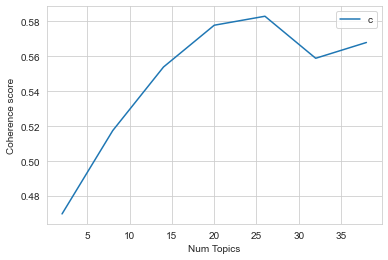

In [45]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4698
Num Topics = 8  has Coherence Value of 0.5175
Num Topics = 14  has Coherence Value of 0.5539
Num Topics = 20  has Coherence Value of 0.5778
Num Topics = 26  has Coherence Value of 0.583
Num Topics = 32  has Coherence Value of 0.5589
Num Topics = 38  has Coherence Value of 0.5679


In [47]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [49]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_lemmatized)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5999,"get, send, hotmail, good, know, think, aol, se...","[nice, dinner, probably, know, anytime, go, lu..."
1,1,12.0,0.3513,"agreement, doc, attach, section, comment, chan...","[absolutely, sheila_tweed, pm, corp, enron, en..."
2,2,17.0,0.3719,"thank, know, enron, send, need, let, get, forw...","[christine, apology, schedule, melt, talk, mon..."
3,3,14.0,0.3822,"report, trade, agreement, credit, carol_st, da...","[vince, uk, var, breach, limit, last, week, uk..."
4,4,12.0,0.4918,"agreement, doc, attach, section, comment, chan...","[problem, comment, forward, corp, enron, pm, h..."
5,5,1.0,0.9219,"power, say, energy, state, california, price, ...","[certainly, agree, tip, iceberg, point, watch,..."
6,6,9.0,0.5502,"deal, thank, know, let, day, change, book, nee...","[kim, also, invite, mike_robert]"
7,7,8.0,0.5137,"http, click, image, email, time, information, ...","[wish, unsubscribe, click, http, d, receive, e..."
8,8,16.0,0.5865,"hour, start, final_schedule, txt, file_portlan...","[start, date_hourahead, hour, awarded_variance..."
9,9,6.0,0.8100,"get, send, hotmail, good, know, think, aol, se...","[still, school, call, work]"


In [57]:
df_dominant_topic.Keywords.iloc[2]

'thank, know, enron, send, need, let, get, forward, work, call'

In [52]:
topic_colour_gen = []
for i in range(0,num_topics):
    topic_colour_gen.append((i, Tableau_20.hex_colors[i]))
    
topic_colours = dict(topic_colour_gen)

In [53]:
chdir('/Users/aydafarhadi/Documents/GitMop/Emails/text_files')

In [54]:
from nltk.stem.wordnet import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from collections import defaultdict
import re

doc = ''

def match_words(word):
    word_edit = word.lower()
    try:
        word_edit = tokenizer.tokenize(word_edit)[0]
    except:
        pass
    return wordnet_lemmatizer.lemmatize(word_edit)
    
def build_html_colour(word, topic):
    #return " <font color=" + str(topic_colours[topic]) + "'>" + word + "</font> "
    return ' <span style="background-color: ' + str(topic_colours[topic])  +'">' + word + '</span>'

def read_doc(doc):
    doc = open(str(doc),'r').read()
    
    # Variables so recalculation is not necessary
    doc_split = doc.split()
    
    # Build dictionary of topic's distribution for a given document
    num_topics_weight = 0
    Topics = defaultdict(int)
    for word in doc_split:
        word_edit = match_words(word)
        try:
            word_topics = ldamodel.get_term_topics(word_edit)
            if word_topics:
                for topic in word_topics:
                    Topics[topic[0]] += topic[1]
                    num_topics_weight += topic[1]            
        except:
            pass
    # Find topic info
    # Append Topic, number of words in document from given topic and doc percentage of topic
    Topic_info = []
    for topic in Topics:
        Topic_info.append([topic, Topics[topic], round((Topics[topic]/num_topics_weight)*100)]) 
    
    # Topic info for three most prevalent topics for a given document
    Topic_info_top3 = []
    Topic_info_copy = []
    for i in Topic_info:
        Topic_info_copy.append(i)
    
    for i in range(0,3):
        max = Topic_info_copy[0]
        for topic in Topic_info_copy:
            if topic[2] > max[2]:
                max = topic
        Topic_info_top3.append(max)
        Topic_info_copy.remove(max)
        
    
    # Format the document according to topics
    for word in doc_split:
        word_edit = match_words(word)
        try:
            topic = ldamodel.get_term_topics(word_edit)[0][0]
            if (topic == Topic_info_top3[0][0]) or (topic == Topic_info_top3[1][0]) or (topic == Topic_info_top3[2][0]):
                doc = doc.replace( ' ' + word + '', build_html_colour(word,topic))
                #doc = doc.replace( '' + word + ' ', build_html_colour(word,topic))
        except:
            pass
    doc = re.sub(r'\n','<br>',doc)
    
    Output = []
    for item in Topic_info_top3:
        colour = build_html_colour('Topic ' + str(item[0]), item[0])
        topic_info = colour + ': ' + str(item[2]) + '% ' + str(Topic_words[item[0]])
        Output.append(topic_info)
    return Output, doc


In [55]:
doc = 'dickson-s_10.'

from IPython.display import HTML

input_form = """
<div style="background-color:white; border:solid black; width:1100px; padding:20px;">
<p>"""+read_doc(doc)[0][0]+"""</p>
<p>"""+read_doc(doc)[0][1]+"""</p>
<p>"""+read_doc(doc)[0][2]+"""</p>
<p>"""+read_doc(doc)[1]+"""</p>
</div>
"""

HTML(input_form) # + javascript)